In [1]:
from __future__ import print_function
import nltk
import os

# Setup nltk corpora path
nltk_path = os.sep.join([os.environ['HOME'], 'nltk_data'])
nltk.data.path.insert(0, nltk_path)

In [2]:
import requests
from bs4 import BeautifulSoup
import scipy.io
import matplotlib.pyplot as plt
import matplotlib 
import pandas as pd
import numpy as np
import pickle
from time import sleep
import timeit
import string
import re

#import snips as snp  # my snippets
#snp.prettyplot(matplotlib)  # my aesthetic preferences for plotting
%matplotlib inline

In [3]:
pkl_filename_master = "df_games.pkl"
with open(pkl_filename_master, 'rb') as picklefile: 
    df_games = pickle.load(picklefile)

In [4]:
test_df = df_games.copy()

In [5]:
test_df.columns

Index([u'id', u'name', u'year_released', u'geek_rating', u'average_rating',
       u'nrate', u'pic_url', u'url', u'index1', u'min_players', u'max_players',
       u'description', u'category', u'attributes'],
      dtype='object')

In [6]:
test_df = test_df.drop([ u'id', u'year_released', u'geek_rating', u'average_rating', 
       u'nrate', u'pic_url', u'url', u'index1', u'min_players', u'max_players', 
     u'category', u'attributes'], axis =1)

In [8]:
import string
import re
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

In [9]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(str(text)) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(str(token))
    stems = [str(stemmer.stem(t)) for t in filtered_tokens]
    #print(stems)
    return stems


In [11]:
pkl_filename_master = "stop_words.pkl"
with open(pkl_filename_master, 'rb') as picklefile: 
    stop_words= pickle.load(picklefile)

In [12]:

def get_wordnet_pos(treebank_tag):
    """Convert the part-of-speech naming scheme
       from the nltk default to that which is
       recognized by the WordNet lemmatizer"""

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

    
def preprocess_series_text(data, nltk_path=nltk_path):
    """Perform complete preprocessing on a Pandas series
       including removal of alpha numerical words, normalization,
       punctuation removal, tokenization, stop word removal, 
       and lemmatization."""
    
    # remove alpha numerical words and make lowercase
    alphanum_re = re.compile(r"""\w*\d\w*""")
    alphanum_lambda = lambda x: alphanum_re.sub('', x.strip().lower())

    data = data.map(alphanum_lambda)

    # remove punctuation
    punc_re = re.compile('[%s]' % re.escape(string.punctuation))
    punc_lambda = lambda x: punc_re.sub(' ', x)

    data = data.map(punc_lambda)

    # tokenize words
    data = data.map(word_tokenize)

    # remove stop words
    sw = stop_words
    #sw = stopwords.words('english')
    sw_lambda = lambda x: list(filter(lambda y: y not in sw, x))

    data = data.map(sw_lambda)

    # part of speech tagging--must convert to format used by lemmatizer
    data = data.map(nltk.pos_tag)
    pos_lambda = lambda x: [(y[0], get_wordnet_pos(y[1])) for y in x]
    data = data.map(pos_lambda)

    # lemmatization
    lemmatizer = WordNetLemmatizer()
    lem_lambda = lambda x: [lemmatizer.lemmatize(*y) for y in x]
    data = data.map(lem_lambda)
    
    return data

In [13]:
test_df['tokens'] = preprocess_series_text(test_df['description'])

In [14]:
test_df.iloc[1][2]

[u'tile',
 u'placement',
 u'draw',
 u'place',
 u'tile',
 u'piece',
 u'southern',
 u'french',
 u'landscape',
 u'tile',
 u'might',
 u'feature',
 u'city',
 u'road',
 u'cloister',
 u'grassland',
 u'combination',
 u'thereof',
 u'place',
 u'adjacent',
 u'tile',
 u'already',
 u'play',
 u'way',
 u'city',
 u'connect',
 u'city',
 u'road',
 u'road',
 u'etcetera',
 u'place',
 u'tile',
 u'decide',
 u'place',
 u'meeples',
 u'area',
 u'city',
 u'knight',
 u'road',
 u'robber',
 u'cloister',
 u'monk',
 u'grass',
 u'farmer',
 u'area',
 u'complete',
 u'meeple',
 u'owner',
 u'face',
 u'decision',
 u'like',
 u'really',
 u'worth',
 u'put',
 u'last',
 u'meeple',
 u'tile',
 u'expand',
 u'city',
 u'place',
 u'near',
 u'opponent',
 u'instead',
 u'give',
 u'hard',
 u'complete',
 u'project',
 u'since',
 u'place',
 u'tile',
 u'option',
 u'place',
 u'meeple',
 u'turn',
 u'proceed',
 u'quickly',
 u'even',
 u'full',
 u'option',
 u'possibility']

In [15]:
test_df

,name,description,tokens
0,Catan,"In Catan (formerly The Settlers of Catan), pla...","[formerly, settler, dominant, force, island, b..."
1,Carcassonne,Carcassonne is a tile-placement game in which ...,"[tile, placement, draw, place, tile, piece, so..."
2,Pandemic,"In Pandemic, several virulent diseases have br...","[several, virulent, disease, break, simultaneo..."
3,Dominion,(from the back of the box:)&#10;&#10;&quot;You...,"[back, box, monarch, like, parent, ruler, smal..."
4,7 Wonders,You are the leader of one of the 7 great citie...,"[leader, great, city, ancient, world, gather, ..."
5,Ticket to Ride,"With elegantly simple gameplay, Ticket to Ride...","[elegantly, simple, gameplay, learn, minute, p..."
6,Agricola,Description from BoardgameNews&#10;&#10;In Agr...,"[boardgamenews, agricola, farmer, wooden, shac..."
7,Puerto Rico,In Puerto Rico players assume the roles of col...,"[puerto, rico, assume, role, colonial, governo..."
8,Small World,"In Small World, players vie for conquest and c...","[small, world, vie, conquest, control, world, ..."
9,Power Grid,Power Grid is the updated release of the Fried...,"[power, grid, update, release, friedemann, fri..."


In [41]:
from gensim import corpora

dictionary = corpora.Dictionary(test_df.tokens)

# This command can be used to filter the dictionary results
dictionary.filter_extremes(no_below=10, no_above=0.5)

In [42]:
type(dictionary)

gensim.corpora.dictionary.Dictionary

In [43]:
corpus = [dictionary.doc2bow(text) for text in test_df.tokens]


In [44]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 2130
Number of documents: 1600


In [45]:
from gensim.models import LdaModel

# Set training parameters.
num_topics = 20
chunksize = 2000
passes = 10
iterations = 500
eval_every = None  # Model perplexity takes quite a lot of time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is to force Gensim to load the dictionary.
id2word = dictionary.id2token

model = LdaModel(corpus=corpus, id2word=id2word, 
                       chunksize=chunksize,
                       alpha='auto', 
                       eta='auto',
                       iterations=iterations, 
                       num_topics=num_topics,
                       passes=passes, 
                       eval_every=eval_every)

In [46]:
model.show_topics()

[(12,
  u'0.014*"wonder" + 0.011*"war" + 0.011*"people" + 0.008*"fight" + 0.008*"nation" + 0.008*"box" + 0.007*"event" + 0.007*"action" + 0.006*"ring" + 0.006*"build"'),
 (8,
  u'0.011*"place" + 0.011*"round" + 0.010*"timeline" + 0.009*"mdash" + 0.008*"treasure" + 0.007*"hand" + 0.007*"escape" + 0.006*"bull" + 0.006*"color" + 0.006*"four"'),
 (0,
  u'0.020*"piece" + 0.017*"set" + 0.011*"move" + 0.010*"scenario" + 0.007*"standard" + 0.006*"opponent" + 0.006*"emperor" + 0.006*"miniature" + 0.006*"unit" + 0.006*"war"'),
 (14,
  u'0.014*"guess" + 0.013*"team" + 0.012*"move" + 0.011*"animal" + 0.010*"space" + 0.010*"word" + 0.009*"place" + 0.007*"settlement" + 0.007*"round" + 0.006*"answer"'),
 (9,
  u'0.015*"zombie" + 0.014*"car" + 0.013*"race" + 0.007*"war" + 0.006*"base" + 0.006*"set" + 0.005*"star" + 0.005*"knight" + 0.005*"factory" + 0.005*"deck"'),
 (15,
  u'0.022*"deck" + 0.020*"round" + 0.018*"hand" + 0.015*"character" + 0.014*"play" + 0.012*"face" + 0.012*"draw" + 0.012*"win" + 0.0

In [47]:
from pprint import pprint

top_topics = model.top_topics(corpus, num_words=10)
pprint(top_topics)

[([(0.031407355848984915, u'monster'),
   (0.02218671964449739, u'dungeon'),
   (0.015144672050783292, u'level'),
   (0.012894496045640972, u'deck'),
   (0.01148908290634104, u'treasure'),
   (0.011215212321590905, u'power'),
   (0.010229913418607831, u'character'),
   (0.0097876624681212665, u'encounter'),
   (0.009680882103626335, u'hero'),
   (0.0083982194111061545, u'defeat')],
  -65.544557047984384),
 ([(0.025069440077537371, u'war'),
   (0.019955746672737806, u'battle'),
   (0.011021250703528241, u'army'),
   (0.010723433852163001, u'deck'),
   (0.010050785238881798, u'power'),
   (0.008758892401085518, u'set'),
   (0.0087186432844777711, u'world'),
   (0.0081879721560717319, u'control'),
   (0.0072448654619279703, u'faction'),
   (0.0071508730208008405, u'enemy')],
  -66.982165573886192),
 ([(0.020636096956307123, u'good'),
   (0.013532523233188804, u'round'),
   (0.013260994696392445, u'ship'),
   (0.0094330051762187891, u'trade'),
   (0.0089583624508012705, u'money'),
   (0.00

In [48]:
import pyLDAvis, pyLDAvis.gensim
from IPython.display import display

# Setup to run in Jupyter notebook
pyLDAvis.enable_notebook()

# Create the visualization
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)

# Export as a standalone HTML web page
pyLDAvis.save_html(vis, 'lda.html')

# Let's view it!
display(vis)

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
13     9.226148        1       1 -0.080505  0.029620
18     7.925897        1       2  0.085366 -0.033788
1      7.576158        1       3  0.056417  0.065835
15     7.019218        1       4 -0.113641 -0.086669
4      6.818990        1       5 -0.028759  0.065641
11     6.636534        1       6  0.137041 -0.022450
5      6.363863        1       7  0.008397  0.082383
3      5.545788        1       8 -0.086656 -0.009607
19     4.906778        1       9  0.048601  0.064462
10     4.701400        1      10  0.019779 -0.090714
7      4.666803        1      11 -0.082523  0.035382
6      4.537058        1      12  0.090109 -0.096113
2      3.617906        1      13 -0.032873 -0.012274
17     3.608089        1      14 -0.087289 -0.021209
16     3.384414        1      15  0.015643  0.012087
9      3.116439        1      16  0.067429  0.027914
14     2.938568        1      17 -0.064000 -0.000674
0      2.603794        1      18  0.042992  0.010206
12     2.429903        1      19  0.027129  0.002523
8      2.376252        1      20 -0.022658 -0.022554, topic_info=     Category        Freq       Term       Total  loglift  logprob
term                                                              
665   Default  915.000000       tile  915.000000  30.0000  30.0000
2098  Default  429.000000      piece  429.000000  29.0000  29.0000
747   Default  296.000000    monster  296.000000  28.0000  28.0000
518   Default  410.000000       ship  410.000000  27.0000  27.0000
496   Default  391.000000        war  391.000000  26.0000  26.0000
764   Default  877.000000      place  877.000000  25.0000  25.0000
1901  Default  170.000000    dungeon  170.000000  24.0000  24.0000
589   Default  722.000000      round  722.000000  23.0000  23.0000
1072  Default  554.000000   building  554.000000  22.0000  22.0000
903   Default  441.000000      color  441.000000  21.0000  21.0000
137   Default  703.000000       deck  703.000000  20.0000  20.0000
1737  Default  140.000000     animal  140.000000  19.0000  19.0000
313   Default  312.000000       hero  312.000000  18.0000  18.0000
778   Default  686.000000       city  686.000000  17.0000  17.0000
935   Default  408.000000       good  408.000000  16.0000  16.0000
1754  Default  644.000000       move  644.000000  15.0000  15.0000
560   Default  375.000000     battle  375.000000  14.0000  14.0000
739   Default  404.000000      space  404.000000  13.0000  13.0000
425   Default  452.000000  character  452.000000  12.0000  12.0000
992   Default  128.000000      tower  128.000000  11.0000  11.0000
199   Default  514.000000       hand  514.000000  10.0000  10.0000
1338  Default  803.000000      build  803.000000   9.0000   9.0000
1555  Default   89.000000     zombie   89.000000   8.0000   8.0000
864   Default  223.000000   treasure  223.000000   7.0000   7.0000
1154  Default  806.000000     action  806.000000   6.0000   6.0000
962   Default  325.000000      money  325.000000   5.0000   5.0000
646   Default   87.000000        car   87.000000   4.0000   4.0000
887   Default  104.000000     wonder  104.000000   3.0000   3.0000
1210  Default  184.000000  adventure  184.000000   2.0000   2.0000
586   Default  270.000000       team  270.000000   1.0000   1.0000
...       ...         ...        ...         ...      ...      ...
582   Topic20   18.413403     temple  101.958668   2.0282  -5.1530
100   Topic20   15.829837       risk   87.166466   2.0337  -5.3042
71    Topic20   17.203854    survive   98.117886   1.9986  -5.2210
1373  Topic20    7.584486       ruin   41.141657   2.0487  -6.0400
1633  Topic20    7.477245    harvest   41.888802   2.0165  -6.0543
85    Topic20   16.395316       room  126.199432   1.6988  -5.2691
864   Topic20   25.219759   treasure  223.050138   1.5599  -4.8385
1651  Topic20    6.647072      dealt   39.274637   1.9632  -6.1719
2049  Topic20   27.620185      mdash  297.52

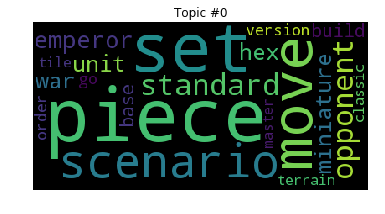

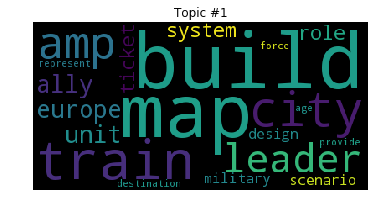

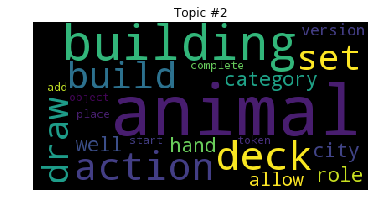

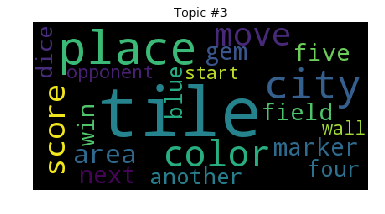

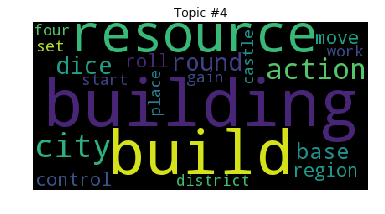

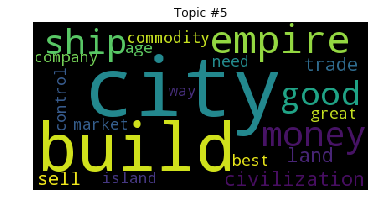

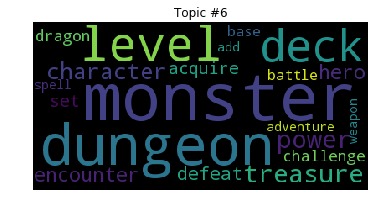

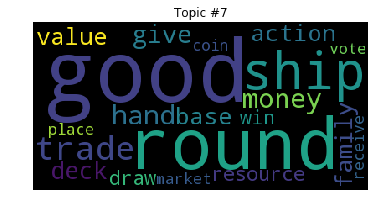

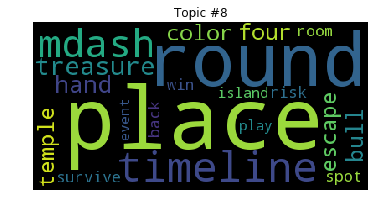

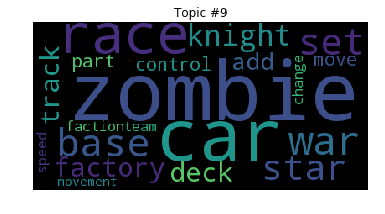

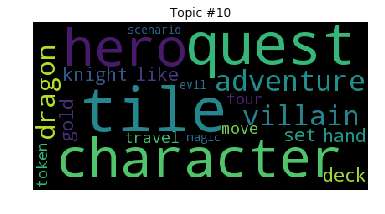

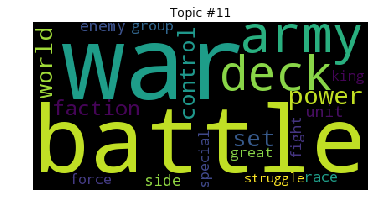

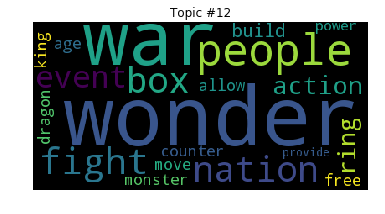

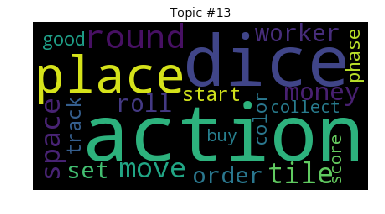

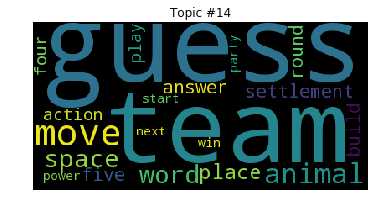

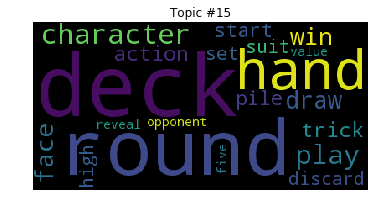

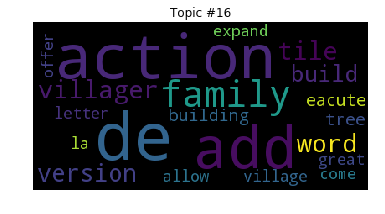

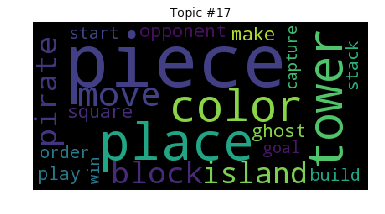

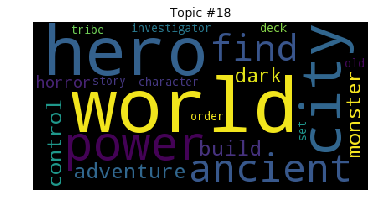

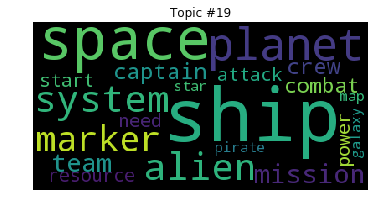

In [49]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
for t in range(model.num_topics):
    plt.figure()
    plt.imshow(WordCloud().fit_words(dict(model.show_topic(t, 20))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

Try to get the cluster of each game:

In [50]:
def get_doc_topic(corpus, model): 
    doc_topic = list() 
    for doc in corpus: 
        doc_topic.append(model.__getitem__(doc, eps=0)) 
    #print(doc_topic)
    return doc_topic 

In [51]:
group_prediction = get_doc_topic(corpus, model)

In [52]:
def get_topic_to_wordids(model): 
        p = list() 
        for topicid in range(model.num_topics): 
            topic = model.state.get_lambda()[topicid] 
            topic = topic / topic.sum() # normalize to probability dist 
            p.append(topic) 
        return p 

In [53]:
get_topic_to_wordids(model)

[array([  1.23655952e-04,   6.55867425e-05,   8.92147871e-05, ...,
          2.77380886e-04,   2.87426881e-05,   2.12255177e-05]),
 array([  3.20941887e-04,   2.60287122e-05,   3.37837451e-05, ...,
          4.03463932e-04,   1.13221386e-05,   8.36058149e-06]),
 array([  2.44505000e-04,   2.16337794e-04,   7.05598760e-05, ...,
          1.13851124e-04,   2.12371754e-05,   1.54136507e-04]),
 array([  4.60556833e-05,   4.75163919e-04,   2.15552263e-03, ...,
          3.33309689e-04,   1.62057029e-05,   1.16490791e-05]),
 array([  3.54284401e-04,   2.70555553e-04,   2.78144593e-04, ...,
          3.47400512e-05,   1.33273662e-05,   9.75797380e-06]),
 array([  4.00859953e-05,   3.31705211e-05,   4.32758496e-05, ...,
          4.08203201e-04,   1.38899580e-05,   1.02569579e-05]),
 array([  4.93663683e-05,   2.63534653e-04,   1.05324730e-03, ...,
          5.83069850e-04,   3.20399804e-04,   3.55556307e-04]),
 array([  4.68538162e-04,   9.28524455e-05,   6.10170247e-04, ...,
          4.3539

In [54]:
group_prediction[1][1][1]

0.00049668979428267753

In [55]:
keep = [[x[1] for x in document] for document in group_prediction]
keep

[[0.0001557728312259476,
  0.00021140577148193233,
  0.00016946562321042271,
  0.17748535874623211,
  0.45237478371213896,
  0.037180724432084665,
  0.00018500301428077124,
  0.00017757631147404172,
  0.00015235444020373262,
  0.00016146968191239964,
  0.00018183625881787422,
  0.00019208634319177145,
  0.00014748110026838778,
  0.2572624281874778,
  0.00015922197811832299,
  0.00019965521512025787,
  0.00016991469252686464,
  0.00017249290752898062,
  0.00021927447385786222,
  0.073041694278846825],
 [0.00036598232372967658,
  0.00049668979428267753,
  0.00039815301607304274,
  0.83511221501884692,
  0.00046966567862869731,
  0.15721829446219387,
  0.00043465752359122839,
  0.00041720876869952072,
  0.00035795094444562002,
  0.00037936685706427633,
  0.00042721735245311717,
  0.00045129953461555918,
  0.00034650121820115651,
  0.00054651955504106875,
  0.00037408596275723919,
  0.00046908231043529016,
  0.00039920808729857821,
  0.00040526550507884109,
  0.00051517701029992998,
  0.00

In [56]:
columns = range(num_topics)
column_list = ['group '+ str(num) for num in columns]
#column_list
df_group = pd.DataFrame([[x[1] for x in document] for document in group_prediction],columns=column_list )
df_group

,group 0,group 1,group 2,group 3,group 4,group 5,group 6,group 7,group 8,group 9,group 10,group 11,group 12,group 13,group 14,group 15,group 16,group 17,group 18,group 19
0,0.000156,0.000211,0.000169,0.177485,0.452375,0.037181,0.000185,0.000178,0.000152,0.000161,0.000182,0.000192,0.000147,0.257262,0.000159,0.000200,0.000170,0.000172,0.000219,0.073042
1,0.000366,0.000497,0.000398,0.835112,0.000470,0.157218,0.000435,0.000417,0.000358,0.000379,0.000427,0.000451,0.000347,0.000547,0.000374,0.000469,0.000399,0.000405,0.000515,0.000415
2,0.000314,0.701836,0.000342,0.000379,0.291648,0.000384,0.000373,0.000358,0.000307,0.000326,0.000367,0.000387,0.000297,0.000469,0.000321,0.000403,0.000343,0.000348,0.000442,0.000357
3,0.000307,0.000416,0.000334,0.000370,0.072127,0.000376,0.000364,0.000350,0.000300,0.000318,0.000358,0.000378,0.000290,0.478581,0.000314,0.000393,0.000335,0.000340,0.443400,0.000348
4,0.000262,0.000355,0.000285,0.000315,0.000336,0.000320,0.000311,0.000298,0.000256,0.000271,0.000305,0.000323,0.994131,0.000391,0.000267,0.000335,0.000285,0.000290,0.000368,0.000297
5,0.000281,0.993812,0.000306,0.000339,0.000360,0.000344,0.000334,0.000320,0.000275,0.000291,0.000328,0.000346,0.000266,0.000419,0.000287,0.000360,0.000306,0.000311,0.000395,0.000319
6,0.000238,0.000323,0.000259,0.000287,0.000306,0.000291,0.000283,0.000271,0.000233,0.000247,0.000278,0.000294,0.000225,0.000356,0.000243,0.283973,0.711023,0.000264,0.000335,0.000270
7,0.000200,0.000272,0.367376,0.000242,0.072782,0.000245,0.000238,0.555859,0.000196,0.000208,0.000234,0.000247,0.000190,0.000299,0.000205,0.000257,0.000219,0.000222,0.000282,0.000227
8,0.000264,0.000358,0.000287,0.086861,0.000339,0.000323,0.000314,0.000301,0.000258,0.000274,0.000308,0.814527,0.000250,0.000394,0.000270,0.093418,0.000288,0.000292,0.000372,0.000300
9,0.000278,0.000377,0.124315,0.000335,0.000357,0.214723,0.000330,0.000317,0.000272,0.000288,0.000324,0.000343,0.000263,0.000415,0.000284,0.000356,0.000303,0.000308,0.655497,0.000316


In [57]:
df_group['max_group'] = df_group.idxmax(axis =1)

In [58]:
df_group['index1'] = df_group.index

In [59]:
test_df['index1'] = test_df.index

add the game names to the dataframe:

In [60]:
df_groups_names = pd.merge(test_df, df_group, on='index1')

In [61]:
df_groups_names

,name,description,tokens,index1,group 0,group 1,group 2,group 3,group 4,group 5,...,group 11,group 12,group 13,group 14,group 15,group 16,group 17,group 18,group 19,max_group
0,Catan,"In Catan (formerly The Settlers of Catan), pla...","[formerly, settler, dominant, force, island, b...",0,0.000156,0.000211,0.000169,0.177485,0.452375,0.037181,...,0.000192,0.000147,0.257262,0.000159,0.000200,0.000170,0.000172,0.000219,0.073042,group 4
1,Carcassonne,Carcassonne is a tile-placement game in which ...,"[tile, placement, draw, place, tile, piece, so...",1,0.000366,0.000497,0.000398,0.835112,0.000470,0.157218,...,0.000451,0.000347,0.000547,0.000374,0.000469,0.000399,0.000405,0.000515,0.000415,group 3
2,Pandemic,"In Pandemic, several virulent diseases have br...","[several, virulent, disease, break, simultaneo...",2,0.000314,0.701836,0.000342,0.000379,0.291648,0.000384,...,0.000387,0.000297,0.000469,0.000321,0.000403,0.000343,0.000348,0.000442,0.000357,group 1
3,Dominion,(from the back of the box:)&#10;&#10;&quot;You...,"[back, box, monarch, like, parent, ruler, smal...",3,0.000307,0.000416,0.000334,0.000370,0.072127,0.000376,...,0.000378,0.000290,0.478581,0.000314,0.000393,0.000335,0.000340,0.443400,0.000348,group 13
4,7 Wonders,You are the leader of one of the 7 great citie...,"[leader, great, city, ancient, world, gather, ...",4,0.000262,0.000355,0.000285,0.000315,0.000336,0.000320,...,0.000323,0.994131,0.000391,0.000267,0.000335,0.000285,0.000290,0.000368,0.000297,group 12
5,Ticket to Ride,"With elegantly simple gameplay, Ticket to Ride...","[elegantly, simple, gameplay, learn, minute, p...",5,0.000281,0.993812,0.000306,0.000339,0.000360,0.000344,...,0.000346,0.000266,0.000419,0.000287,0.000360,0.000306,0.000311,0.000395,0.000319,group 1
6,Agricola,Description from BoardgameNews&#10;&#10;In Agr...,"[boardgamenews, agricola, farmer, wooden, shac...",6,0.000238,0.000323,0.000259,0.000287,0.000306,0.000291,...,0.000294,0.000225,0.000356,0.000243,0.283973,0.711023,0.000264,0.000335,0.000270,group 16
7,Puerto Rico,In Puerto Rico players assume the roles of col...,"[puerto, rico, assume, role, colonial, governo...",7,0.000200,0.000272,0.367376,0.000242,0.072782,0.000245,...,0.000247,0.000190,0.000299,0.000205,0.000257,0.000219,0.000222,0.000282,0.000227,group 7
8,Small World,"In Small World, players vie for conquest and c...","[small, world, vie, conquest, control, world, ...",8,0.000264,0.000358,0.000287,0.086861,0.000339,0.000323,...,0.814527,0.000250,0.000394,0.000270,0.093418,0.000288,0.000292,0.000372,0.000300,group 11
9,Power Grid,Power Grid is the updated release of the Fried...,"[power, grid, update, release, friedemann, fri...",9,0.000278,0.000377,0.124315,0.000335,0.000357,0.214723,...,0.000343,0.000263,0.000415,0.000284,0.000356,0.000303,0.000308,0.655497,0.000316,group 18


In [62]:
df_groups_predicted = df_groups_names.groupby('max_group')

In [63]:
df_groups_predicted
    

In [64]:
df_check = df_groups_predicted.aggregate(lambda x: tuple(x))
df_check = df_check.reset_index()
#df_check
games_categories = df_check['name']
for groups in games_categories:
    print(groups) 
    print('\n')

(u'Chess', u'Go', u'Crokinole', u'PitchCar', u'Heroscape Master Set: Rise of the Valkyrie', u'Checkers', u'Twilight Imperium (Third Edition): Shattered Empire', u'Felix: The Cat in the Sack', u'Tide of Iron', u'Chinese Checkers', u'Ascension: Storm of Souls', u'Conquest of the Empire', u'T.I.M.E Stories: The Marcy Case', u'Tic-Tac-Toe', u'Hive: The Mosquito', u'Ogre', u'TZAAR', u'Heroscape Master Set: Swarm of the Marro', u'Warhammer 40,000', u'ZhanGuo', u'Battle Sheep', u'Heroscape Marvel: The Conflict Begins', u'Elk Fest', u'Bingo', u'Hive: The Ladybug', u'Xiangqi', u'Kings & Things', u'Mesopotamia', u'Coda', u'Takenoko: Chibis', u'Aqua Romana', u'Star Wars Miniatures', u'Warhammer: Diskwars', u'Horus Heresy', u'Eat Poop You Cat', u'Iron Dragon', u'Nottingham', u'Wings of War: Burning Drachens', u'Tyrants of the Underdark')


(u'Pandemic', u'Ticket to Ride', u'Ticket to Ride: Europe', u'Race for the Galaxy', u'Eclipse', u'BANG!', u"Memoir '44", u'Through the Ages: A Story of Civiliza